# Distributing rows across processes

In [1]:
%%time
import numpy as np
import multiprocessing as mp
import sys
NUM_ELEM=100
mat_size = int(np.sqrt(NUM_ELEM))
pre_mat = np.random.rand(NUM_ELEM)
mat = pre_mat.reshape(mat_size,mat_size)
vec = np.random.rand(mat_size)
result = np.dot(mat,vec)
print('Actual result using numpy: {}'.format(result))

Actual result using numpy: [2.90593007 3.05015517 2.34872437 2.47229727 2.76652616 2.8679085
 2.79198289 2.50947453 2.50629186 2.39889227]
CPU times: user 80.8 ms, sys: 86 ms, total: 167 ms
Wall time: 66.5 ms


In [2]:
def row_dist(procs):
    NUMPROCS = procs
    mybounds =[0]*NUMPROCS
    ###############################################################################
    if(NUMPROCS>mat_size):
        sys.exit()
    q = int(mat_size/NUMPROCS)
    rem = int(mat_size%NUMPROCS)          #This block makes sure that rows are
    for j in range(q):                    #divided evenly across processes, no
        for i in range(NUMPROCS):         #process will get not more than 1 row
            mybounds[i]+=1                #compared to other processes. Make sure
    for i in range(rem):                  #that processes<=rows.
        mybounds[i]+=1
    bounds = []
    for i in range(len(mybounds)):
        bounds.append(sum(mybounds[:i+1]))
    bounds=[0]+bounds
    ###############################################################################
    #print(bounds)
    
    def row_mult(row,out_q):
        val = np.dot(row,vec)
        #print(val)
        out_q.put(val)

    sub_vals = mp.Queue()
    jobs = []
    
    for i in range(NUMPROCS):
        l = bounds[i]
        h = bounds[i+1]
        job = mp.Process(target = row_mult, args=[mat[l:h],sub_vals])
        jobs.append(job)
        job.start()
    #for job in jobs:
        #job.start()
        #job.join()

    #global my_final
    my_final = []

    for i in range(NUMPROCS):
        my_final.append(sub_vals.get())
    
    return my_final
    #print('Final product by using {} processes is {}'.format(NUMPROCS,my_final)) 

In [3]:
## ACTUAL RESULTS
n = 1        # Number of loops
r = 10       # Number of repetitions of each loop
p = 6        # Display precision
times = []
NUMPROCS=7
func=[]
for i in range(1,NUMPROCS+1):
    t2 = %timeit -n $n -r $r -p $p -o pass; func.append(row_dist(i))
    times.append(t2.average*1000)
#print('times taken for each of the {} processes is {} in (ms)'.format(NUMPROCS,times))
Sp = [times[0]/items for items in times]
Ep = [Sp[i]/(i+1) for i in range(0,len(Sp))]
import pandas as p
data = {}
for i in range(1,NUMPROCS+1):
    data['Processes='+str(i)] = [times[i-1],Sp[i-1],Ep[i-1],i]
df1 = p.DataFrame(data)
df1 = df1.rename(index={2: 'Ep',1:'Sp',0:'times',3:'Processes'})
print('Table showing timings, Efficiency, Speedup, times in (ms)')
df1=df1.transpose()
display(df1.style)
print('Final result using parallel: {}'.format(func[0]))

The slowest run took 8.04 times longer than the fastest. This could mean that an intermediate result is being cached.
8.20591 ms ± 9.08008 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
8.81205 ms ± 1.2303 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
11.4341 ms ± 1.95957 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
14.0772 ms ± 1.92975 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
17.0016 ms ± 2.26299 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
19.399 ms ± 2.61425 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
22.2703 ms ± 2.76971 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Table showing timings, Efficiency, Speedup, times in (ms)


Final result using parallel: [array([2.90593007, 3.05015517, 2.34872437, 2.47229727, 2.76652616,
       2.8679085 , 2.79198289, 2.50947453, 2.50629186, 2.39889227])]


Text(0,0.5,'log(time)')

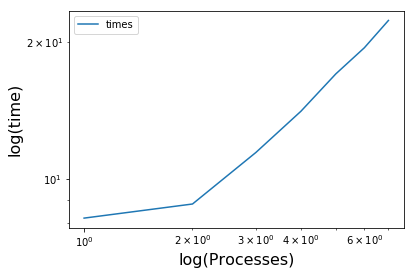

In [4]:
plt1 = df1.plot(x='Processes',y='times',logx=True, logy=True)
plt1.set_xlabel('log(Processes)',fontsize=16)
plt1.set_ylabel('log(time)',fontsize=16)

Text(0,0.5,'Ep')

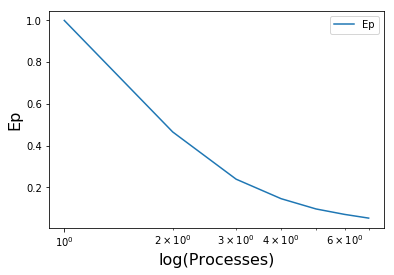

In [5]:
plt2 = df1.plot(x='Processes',y='Ep',logx=True, logy=False)
plt2.set_xlabel('log(Processes)',fontsize=16)
plt2.set_ylabel('Ep',fontsize=16)

# Distributing products across processes

In [6]:
def product_dist(procs):
    NUMPROCS = procs
    mybounds =[0]*NUMPROCS
    q = int(mat_size/NUMPROCS)
    rem = int(mat_size%NUMPROCS)
    for j in range(q):
        for i in range(NUMPROCS):
            mybounds[i]+=1
    for i in range(rem):
        mybounds[i]+=1
    bounds = []
    for i in range(len(mybounds)):
        bounds.append(sum(mybounds[:i+1]))
    bounds=[0]+bounds
    #print(bounds)
    
    def row_mult(mat_elem,vec_elem,out_q):
        val = mat_elem*vec_elem
        for items in val:
            out_q.put(items)


    my_final = []
    #qs = []

    for j in range(mat_size):   ###No.Of rows
        sub_vals = mp.Queue()
        jobs = []
        for i in range(NUMPROCS):
            l = bounds[i]
            h = bounds[i+1]
            job = mp.Process(target = row_mult, args=[mat[j][l:h],vec[l:h],sub_vals])
            job.start()
            jobs.append(job)

        #for job in jobs:
            #job.join()
        one_elem=0
        for i in range(mat_size):
            one_elem+=sub_vals.get()
    
        my_final.append(one_elem)
    
    return my_final

    #print('Final product by using {} processes is {}'.format(NUMPROCS,my_final))

In [7]:
## ACTUAL RESULTS
n = 1        # Number of loops
r = 10       # Number of repetitions of each loop
p = 6        # Display precision
times = []
NUMPROCS=7
func=[]
for i in range(1,NUMPROCS+1):
    t3 = %timeit -n $n -r $r -p $p -o pass; func.append(product_dist(i))
    times.append(t3.average*1000)
#print('times taken for each of the {} processes is {} in (ms)'.format(NUMPROCS,times))
Sp = [times[0]/items for items in times]
Ep = [Sp[i]/(i+1) for i in range(0,len(Sp))]
import pandas as p
data = {}
for i in range(1,NUMPROCS+1):
    data['Processes='+str(i)] = [times[i-1],Sp[i-1],Ep[i-1],i]
df2 = p.DataFrame(data)
df2 = df2.rename(index={2: 'Ep',1:'Sp',0:'times',3:'Processes'})
print('Table showing timings, Efficiency, Speedup, times in (ms)')
df2=df2.transpose()
display(df2.style)
print('Final result using parallel: {}'.format(func[0]))

59.8055 ms ± 6.52132 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
101.469 ms ± 10.0138 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
154.973 ms ± 29.7892 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
185.346 ms ± 32.601 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
217.146 ms ± 20.0579 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
248.363 ms ± 6.29931 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
286.73 ms ± 10.4009 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)
Table showing timings, Efficiency, Speedup, times in (ms)


Final result using parallel: [2.9059300724394403, 3.0501551701033636, 2.34872436977729, 2.472297270989313, 2.7665261614052468, 2.8679084982749448, 2.7919828918444383, 2.509474528062502, 2.506291860709431, 2.398892274768745]


Text(0,0.5,'log(time)')

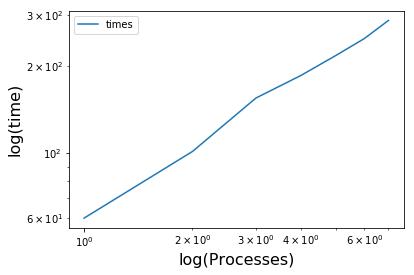

In [8]:
plt1 = df2.plot(x='Processes',y='times',logx=True, logy=True)
plt1.set_xlabel('log(Processes)',fontsize=16)
plt1.set_ylabel('log(time)',fontsize=16)

Text(0,0.5,'Ep')

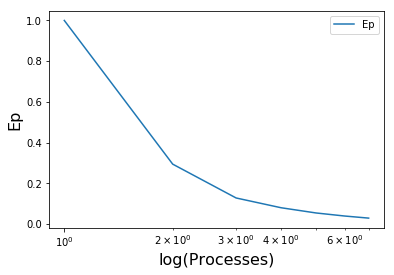

In [9]:
plt2 = df2.plot(x='Processes',y='Ep',logx=True, logy=False)
plt2.set_xlabel('log(Processes)',fontsize=16)
plt2.set_ylabel('Ep',fontsize=16)